# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import scipy.optimize
import scipy.integrate
import scipy.interpolate

import glob

%matplotlib inline

from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from IPython.display import Image

plt.style.use('lato_style.mplstyle')

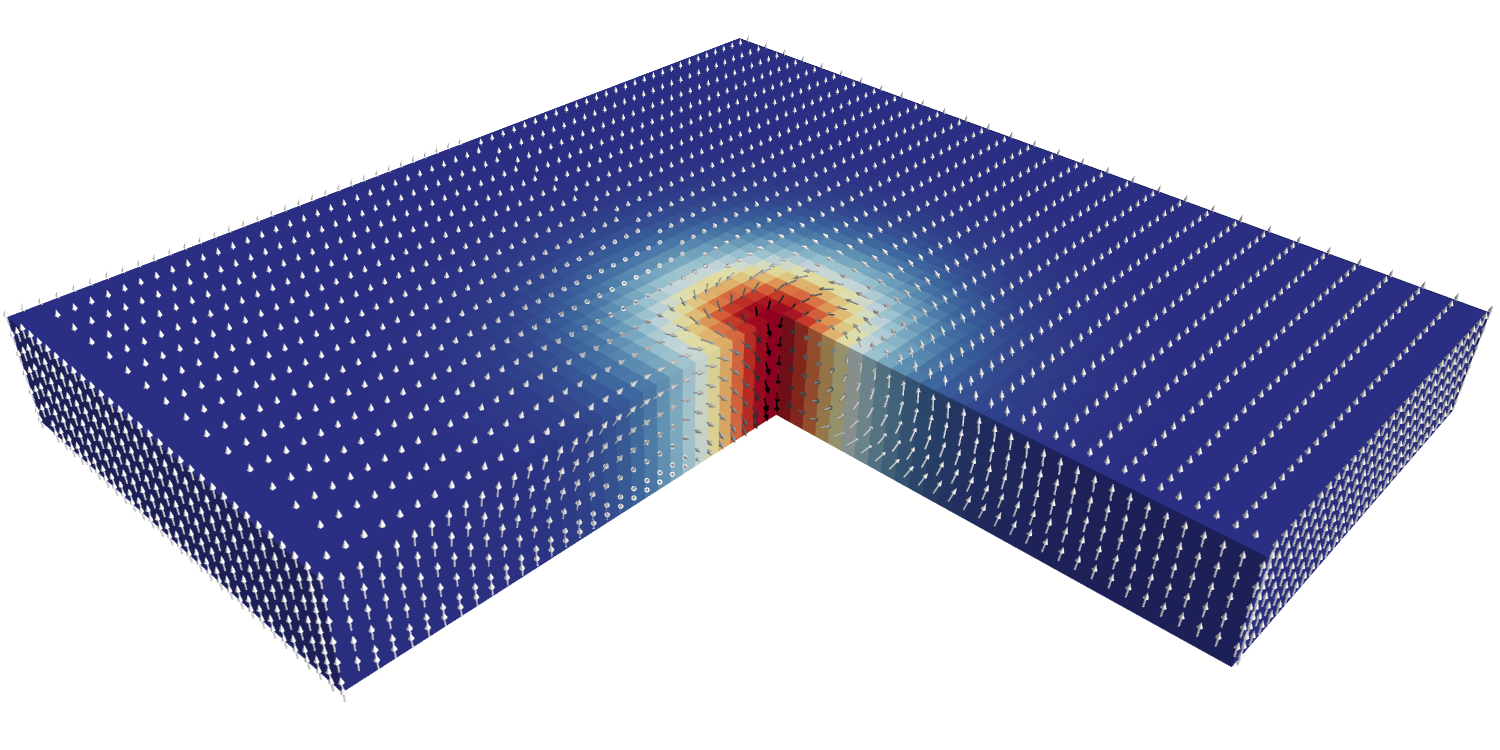

In [2]:
Image('mayavi/system_3d.png')

# Three dimensional skyrmion structure in cuboid with PBCs

Variation of the three dimensional standard problem for the *Proposal for a micromagnetic standard problem for materials with Dzyaloshinskii-Moriya interaction* paper. Periodic boundaries are specified in the $x$ and $y$ directions of a cuboid system.

System:


    * An FeGe cuboid of 180 nm side length (xy plane) and  20 nm thickness (along z direction) with PBCs in the x and y direction
    * Interactions: Exchange:                    8.78e-12  J m**-1
                    DMI:                         1.58e-3   J m**-2
                    Uniaxial Anisotropy along z: 0.51e6    J m**-3
                    

Here we observe a helical rotation along the thickness of the sample, which modifies the skyrmionic structure in every layer.


Relevant paper:

[x] Three-dimensional skyrmion states in thin films of cubic helimagnets. PRB **87**, 094424 (2013).

In [3]:
# System parameters for the finite difference simulations
# Since we use a 3x3x2 nm^3 cell, we use a slightly larger sample size to get
# the right sample dimensions

# Scale in nm
side_length_s = 183 
thickness_s = 22
cell_s = 3
cellz_s = 2

# scales in m
nm = 1e-9
side_length = side_length_s * nm
thickness = thickness_s * nm
cell = cell_s * nm
cellz = cellz_s * nm

# Bulk
A = 8.78e-12
D = 1.58e-3
Ms = 3.84e5
B = 0.4

initial_sk_diam = 20

Relevant parameters: Helix period $L_{D}$ and saturation field $H_{D}$

$$L_{D} = \frac{4\pi A}{|D|} \qquad H_{D}=\frac{D^{2}}{2 A M_{\text{s}}}$$

In [4]:
L_D = 4 * np.pi * A / D
H_D = (D ** 2) / (2 * A * Ms)

print('L_D =', L_D * 1e9, 'nm')
print('mu0 H_D =', H_D, 'T')

print('thickness / L_D = ', thickness / L_D)
print('H / H_D = ', B / H_D)

L_D = 69.83084430004654 nm
mu0 H_D = 0.3702187737281701 T
thickness / L_D =  0.31504702858054
H / H_D =  1.0804422368210223


# Fidimag Simulation

In [5]:
import fidimag
import fidimag.common.constant as C
plt.style.use('lato_style.mplstyle')

Here we specify the Fidimag simulation with periodic boundaries and set a skyrmion as the initial state:

In [6]:
dx, dy, dz = cell_s, cell_s, cellz_s
nx, ny, nz = int(side_length_s / dx), int(side_length_s / dy), int(thickness_s / dz)
mesh = fidimag.common.CuboidMesh(dx=dx, dy=dy, dz=dz, nx=nx, ny=ny, nz=nz,
                                 unit_length=1e-9, 
                                 periodicity=(True, True, False)
                                 )
xs, ys, zs = mesh.coordinates[:, 0], mesh.coordinates[:, 1], mesh.coordinates[:, 2]
centre_x = xs.min() + (xs.max() - xs.min()) * 0.5
centre_y = ys.min() + (ys.max() - ys.min()) * 0.5
centre_z = zs.min() + (zs.max() - zs.min()) * 0.5
# print(centre_x, centre_y)

sim = fidimag.micro.Sim(mesh, name='fidimag_3D')
sim.set_Ms(Ms)

# Make spins point in the opposite direction in a small circular region at
# the middle of the sample to get a skyrmion
# A linear model for the skyrmion profile
def m_init(pos):
    x, y = pos[0] - centre_x, pos[1] - centre_y
    if (x ** 2 + y ** 2) ** 0.5 < initial_sk_diam:
        r = (x ** 2 + y ** 2) ** 0.5
        phi = np.arctan2(y, x) + 0.5 * np.pi
        k = np.pi / initial_sk_diam
        return (np.sin(k * r) * np.cos(phi),
                 np.sin(k * r) * np.sin(phi),
                 -np.cos(k * r))
    else:
        return (0, 0, 1)

sim.set_m(m_init)

sim.add(fidimag.micro.UniformExchange(A=A))
sim.add(fidimag.micro.DMI(D=D, dmi_type='bulk'))
sim.add(fidimag.micro.Zeeman(H0=(0, 0, B / C.mu_0)))
# sim.add(fidimag.micro.UniaxialAnisotropy(Ku, axis=(0, 0, 1)))

We relax the system to stabilise the skyrmion solution:

In [7]:
%%capture
sim.driver.do_precession = False
sim.driver.alpha = 0.5
# sim.driver.set_tols(1e-10, 1e-10)
sim.relax(stopping_dmdt=.01)

We can now extract the data from spins across the center of the system for every $xy$ plane-cut along the $z$ direction 

In [8]:
# Define variables to store all the coordinates
mx_F, my_F, mz_F = (sim.spin.reshape(-1, 3)[:, 0], 
                    sim.spin.reshape(-1, 3)[:, 1], 
                    sim.spin.reshape(-1, 3)[:, 2])

# Redefine them with respect to the centre of the system
r_fidimag = sim.mesh.coordinates
x_F, y_F, z_F = (r_fidimag[:, 0] - centre_x, 
                 r_fidimag[:, 1] - centre_y, 
                 r_fidimag[:, 2] - centre_z)

# We will mask the array to extract only the spins at y=y_mid (middle of the sample)
# and at a specific Z coordinate (i.e. a  plane cut)
xs_F, ys_F, zs_F = np.unique(x_F), np.unique(y_F), np.unique(z_F)

_filter_y_F = lambda z_i: np.logical_and(y_F == ys_F[int(len(ys_F) * 0.5)],
                                          z_F == zs_F[z_i])

# Define functions to show the data at the middle and for a given z index
# i.e. 0 --> z[0] , 1 --> z[1]
mz_fidimag = lambda z_i: mz_F[_filter_y_F(z_i)]
my_fidimag = lambda z_i: my_F[_filter_y_F(z_i)]
mx_fidimag = lambda z_i: mx_F[_filter_y_F(z_i)]
x_fidimag = lambda z_i: x_F[_filter_y_F(z_i)]
y_fidimag = lambda z_i: y_F[_filter_y_F(z_i)]
# z_fidimag = lambda z_i: z[_filter_y_F(z_i)]

# Extract cylindrical componenets of the magnetisation
phi_F = np.arctan2(y_F, x_F)
mphi_fidimag = lambda z_i: (-mx_F * np.sin(phi_F) + my_F * np.cos(phi_F))[_filter_y_F(z_i)]
mr_fidimag = lambda z_i: (mx_F * np.cos(phi_F) + my_F * np.sin(phi_F))[_filter_y_F(z_i)]

We can find the point $x$ such that $m_{z}(x)=0$, which we define as the skyrmion radius, for every slice. We compute this for the bottom layer

In [9]:
for i, z in enumerate(zs_F):
    f = scipy.interpolate.interp1d(x_fidimag(i), mz_fidimag(i), kind='cubic')
    # Skyrmion radius: m_z = 0
    rsk = scipy.optimize.brentq(f, 0, 50)
    
    if i == 0:
        r_sk_F = rsk

    print('At z = {:<5}, r_sk = {:.3f}'.format(z, rsk))

At z = -10.0, r_sk = 15.746
At z = -8.0 , r_sk = 15.823
At z = -6.0 , r_sk = 15.925
At z = -4.0 , r_sk = 16.019
At z = -2.0 , r_sk = 16.084
At z = 0.0  , r_sk = 16.106
At z = 2.0  , r_sk = 16.084
At z = 4.0  , r_sk = 16.019
At z = 6.0  , r_sk = 15.925
At z = 8.0  , r_sk = 15.823
At z = 10.0 , r_sk = 15.746


We can plot the cylindrical components of the magnetisation in two $z$ slices

No handles with labels found to put in legend.


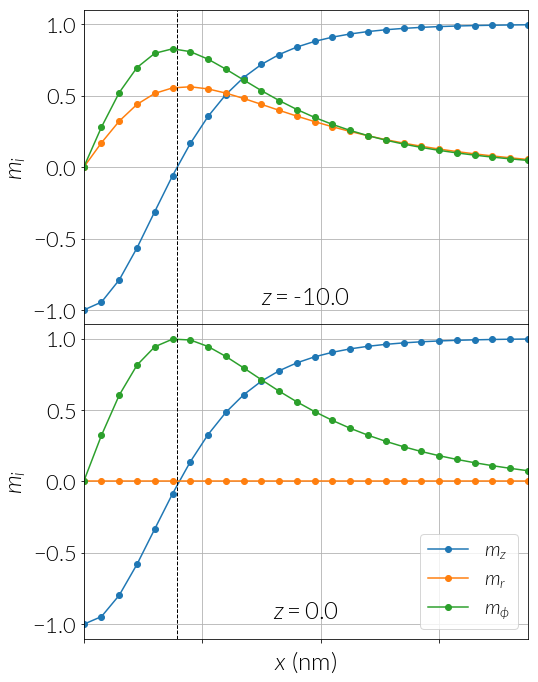

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 16 / 1.6))

# -----------------------------------------------------------------------------
# Plot at zs_F[0] --> this is z = -10 nm

ax1.plot(x_fidimag(0), mz_fidimag(0), 'o-', label=r'$m_{z}$')
ax1.plot(x_fidimag(0), mr_fidimag(0), 'o-', label=r'$m_{r}$')
ax1.plot(x_fidimag(0), mphi_fidimag(0), 'o-', label=r'$m_{\phi}$')

ax1.axvline(x=r_sk_F, color='k', lw=1, ls='--')

ax1.grid()
plt.legend(loc=4)
ax1.set_xlim(0, 75)
ax1.set_ylim(-1.1, 1.1)

ax1.set_xlabel(r'$x$ (nm)')
ax1.set_ylabel(r'$m_{i}$')

ax1.text(0.5, 0.05, r'$z=$' + '{}'.format(zs_F[0]),
         horizontalalignment='center', verticalalignment='bottom', 
         transform=ax1.transAxes)

# -----------------------------------------------------------------------------
# Plot at zs_F[5] --> this is z = 0 nm (middle of the sample)

ax2.plot(x_fidimag(5), mz_fidimag(5), 'o-', label=r'$m_{z}$')
ax2.plot(x_fidimag(5), mr_fidimag(5), 'o-', label=r'$m_{r}$')
ax2.plot(x_fidimag(5), mphi_fidimag(5), 'o-', label=r'$m_{\phi}$')

ax2.axvline(x=r_sk_F, color='k', lw=1, ls='--')

ax2.grid()
ax2.legend(loc=4)
ax2.set_xlim(0, 75)
ax2.set_ylim(-1.1, 1.1)

ax2.set_xlabel(r'$x$ (nm)')
ax2.set_ylabel(r'$m_{i}$')

ax2.text(0.5, 0.05, r'$z=$' + '{}'.format(zs_F[5]),
         horizontalalignment='center', verticalalignment='bottom', 
         transform=ax2.transAxes)

ax2.set_xticklabels([])

# -----------------------------------------------------------------------------

plt.tight_layout()
plt.subplots_adjust(hspace=0)
# plt.savefig('../paper/result_3d.pdf', bbox_inches='tight')

We plot here an overview of the system. We show the cylinrical coordinates and snapshots of the magnetisation at two different $z$ layers, and snapshots of the system with spins drawn at $r=r_{\text{sk}}$, which is defined as the points in a layer where $m_{z}=0$:

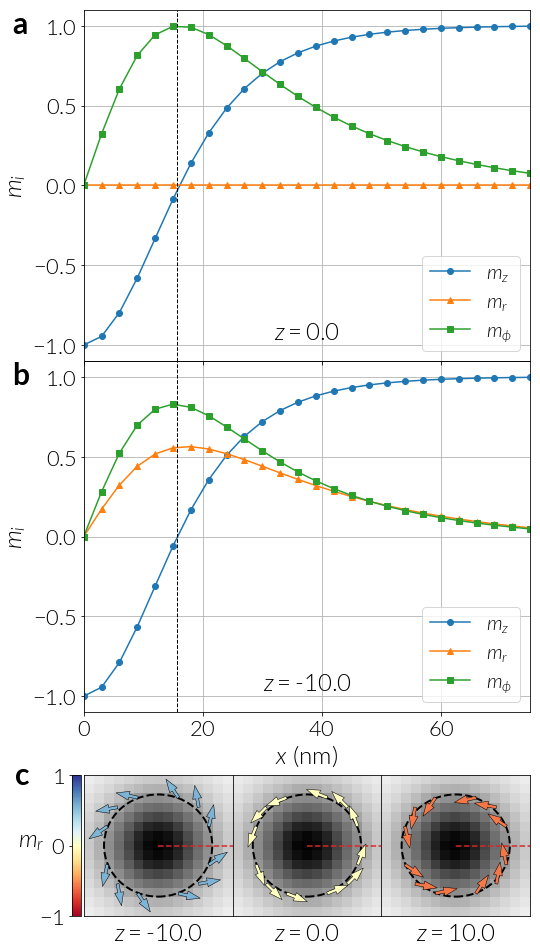

In [11]:
# Adjuts aspect ratios according to gridspec
f = plt.figure(figsize=(8, 16 / 1.6 + 8 / 1.2))
axs = [None] * 5

# Make outer gridspec
# We will design a: 2 X 1 grid of plots, and add a 1 X 3 grid at the bottom
# The bottom plots have half the height of a  normal plot, so we set
# 2 + 2 + 1 in heights  -> 5:1 ratio
outer = gridspec.GridSpec(2, 1, height_ratios = [5, 1])
# Separation of the bottom row of plots from the top grid
outer.update(hspace=0.15)

# Make nested gridspecs
# gs2 will be used to plot snapshots of three cut planes
# We set 2 for the height of the 2 X 1 grid since each of these plots span
# 1 unit of plots. We set the width as 9 since we divide gs2 in 3, thus
# gs1 is divided in 9 (3 rows)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 9, subplot_spec=outer[0], hspace=0.)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 9, subplot_spec=outer[1], hspace=0., wspace=0)

# 2 X 1 grid of plots: heights span 1 unit and widths span 9 units
axs[1] = plt.subplot(gs1[1:, :9])
axs[0] = plt.subplot(gs1[:1, :9], sharex=axs[1])

# 1 X 3 bottom row of plots: heights span 1 unit and widths 3 units
for j, i in enumerate(range(2, 5)):
    axs[i] = plt.subplot(gs2[:, j * 3:(j + 1) * 3])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

# Define markers
marks = ['o', '^', 's']
    
# -----------------------------------------------------------------------------
# Plot at z = 0 nm, which is the index 5

# m components
axs[0].plot(x_fidimag(5), mz_fidimag(5), label=r'$m_{z}$', marker=marks[0])
axs[0].plot(x_fidimag(5), mr_fidimag(5), label=r'$m_{r}$', marker=marks[1])
axs[0].plot(x_fidimag(5), mphi_fidimag(5), label=r'$m_{\phi}$', marker=marks[2])

# Vertical line at the skyrmion radius
axs[0].axvline(x=r_sk_F, color='k', lw=1, ls='--')

axs[0].grid()
axs[0].legend(loc=4)
axs[0].set_xlim(0, 75)
axs[0].set_ylim(-1.1, 1.1)

# axs[0].set_xlabel(r'$x$ (nm)')
axs[0].set_ylabel(r'$m_{i}$')

axs[0].text(0.5, 0.05, r'$z=$' + '{}'.format(zs_F[5]),
         horizontalalignment='center', verticalalignment='bottom', 
         transform=axs[0].transAxes)

plt.setp(axs[0].get_xticklabels(), visible=False)

# -----------------------------------------------------------------------------
# Plot at z = -10 nm, which is the index 0

axs[1].plot(x_fidimag(0), mz_fidimag(0), label=r'$m_{z}$', marker=marks[0])
axs[1].plot(x_fidimag(0), mr_fidimag(0), label=r'$m_{r}$', marker=marks[1])
axs[1].plot(x_fidimag(0), mphi_fidimag(0), label=r'$m_{\phi}$', marker=marks[2])

axs[1].axvline(x=r_sk_F, color='k', lw=1, ls='--')

axs[1].grid()
axs[1].legend(loc=4)
axs[1].set_xlim(0, 75)
axs[1].set_ylim(-1.1, 1.1)

axs[1].set_xlabel(r'$x$ (nm)')
axs[1].set_ylabel(r'$m_{i}$')

axs[1].text(0.5, 0.05, r'$z=$' + '{}'.format(zs_F[0]),
         horizontalalignment='center', verticalalignment='bottom', 
         transform=axs[1].transAxes)


# -----------------------------------------------------------------------------
# Snapshots with the colour map and quiver plot

for i, layer in enumerate([0, 5, -1]):
    i += 2

    # Filter points with Ms=0 and for a specific XY-plane-cut (or Z layer)
    m_filter = np.logical_and(sim.Ms > 1e-5, z_F == zs_F[layer])
    
    # Define a filter to only draw spins at r=r_sk
    xf, yf = x_F[m_filter], y_F[m_filter]
    ring_filter = np.logical_and(xf ** 2 + yf ** 2 >= (r_sk_F - .1) ** 2, 
                                 xf ** 2 + yf ** 2 <= (r_sk_F + 1.5) ** 2)
    
    mr = mx_F * np.cos(phi_F) + my_F * np.sin(phi_F)
    
    # Colour map with the m_z component
    axs[i].imshow(mz_F[m_filter].reshape(ys_F.shape[0], -1), 
                  cmap='Greys_r', 
                  vmin=-1, vmax=1, aspect='auto',
                  extent=[xs_F.min(), xs_F.max(), ys_F.min(), ys_F.max()])

    # Circle at the sk radius. We slightly shift it to match the mesh cells
    circle = plt.Circle((0, 0), int(r_sk_F) + 1, fill='', lw=2, ls='--')
    axs[i].add_artist(circle)
    
    # Quiver plot for spins at r = r_sk
    axs[i].quiver(x_F[m_filter][ring_filter], 
                  y_F[m_filter][ring_filter], 
                  mx_F[m_filter][ring_filter],
                  my_F[m_filter][ring_filter],
                  # Colour according to m_r component
                  mr[m_filter][ring_filter],
                  cmap='RdYlBu',
                  clim=(-1, 1),
                  # Scale the arrows to make them visible
                  width=0.02, scale=1 / 0.15, 
                  headwidth=3, headlength=4.5,
                  edgecolor='k', linewidth=0.5,
                  zorder=3
                  )
    
    # axs[i].set_title('z = {} nm'.format(zs[layer]), fontweight='light')

    # Set limits
    axs[i].set_xlim(-22, 22)
    axs[i].set_ylim(-22, 22)
    
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
    axs[i].text(0.5, -0.05, r'$z=$' + '{}'.format(zs_F[layer]),
                horizontalalignment='center', verticalalignment='top', 
                transform=axs[i].transAxes)
    
    # Draw a line from the skyrmion center to show what data is being 
    # plotted in axs[0] and axs[1]
    xl = np.linspace(0, 25, 20)
    axs[i].plot(xl, np.zeros_like(xl), '--C3')

# -----------------------------------------------------------------------------
# Colorbar of quiver plot to the left of the first snapshot (axes index = 2)
# Get coordinates and size of axes
box = axs[2].get_position()
# Define axes for the colourbar:
axColor = plt.axes([box.x0 - 0.02, box.y0, 
                    0.015, box.height])
cb = plt.colorbar(axs[2].get_children()[0], cax=axColor, orientation="vertical")
cb.set_ticks([-1, 0, 1])
# Put the colorbar labels to the left:
cb.ax.yaxis.set_ticks_position('left')
# Specify the colorbar label:
cb.set_label(r'$m_{r}$', fontsize=24, rotation=0, labelpad=-50, y=0.6)

# -----------------------------------------------------------------------------
# Label every plot: a, b, c, ...
for j, i in enumerate(['a', 'b']):
    axs[j].text(-0.16, 1, i, fontweight='bold', fontsize=30,
                horizontalalignment='left', verticalalignment='top', 
                transform=axs[j].transAxes)

axs[2].text(-0.46, 1.1, 'c', fontweight='bold', fontsize=30,
            horizontalalignment='left', verticalalignment='top', 
            transform=axs[2].transAxes)

plt.savefig('../paper/result_3d.pdf', bbox_inches='tight')

We can plot the $m_{x}$ component at the bottom and top of the sample:

Text(0,0.5,'$m_{x}$')

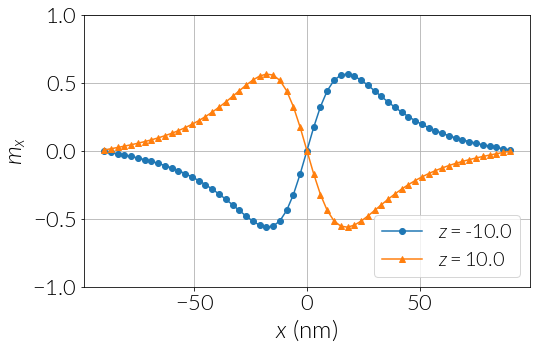

In [12]:
plt.plot(x_fidimag(0), mx_fidimag(0), 'o-', label=r'$z=$' + '{}'.format(zs_F[0]))
# plt.plot(x_fidimag(0) - centre_x, mz_fidimag(0))
plt.plot(x_fidimag(-1), mx_fidimag(-1), '^-', label=r'$z=$' + '{}'.format(zs_F[-1]))
plt.grid()
plt.legend(loc=4)
plt.ylim(-1, 1)

plt.xlabel(r'$x$ (nm)')
plt.ylabel(r'$m_{x}$')

Or the radial component:

Text(0,0.5,'$m_{r}$')

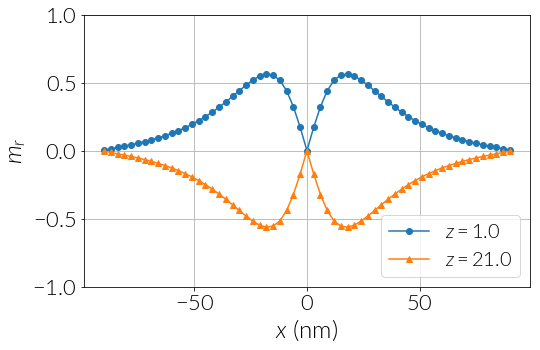

In [13]:
plt.plot(x_fidimag(0), mr_fidimag(0), 'o-', label=r'$z=$' + '{}'.format(zs[0]))
plt.plot(x_fidimag(-1), mr_fidimag(-1), '^-', label=r'$z=$' + '{}'.format(zs[-1]))

plt.grid()
plt.legend(loc=4)
plt.ylim(-1, 1)

plt.xlabel(r'$x$ (nm)')
plt.ylabel(r'$m_{r}$')

From [PRB **87**, 094424 (2013)], we define $\mathbf{m}=(\sin\Theta\cos\Psi,\sin\Theta\sin\Psi,\cos\Theta)$ and we can use the ansatz $\Psi(z,\phi)=\phi+\pi/2+\tilde{\Psi}(z)$. 

If we specify the skyrmion radius as $r_{\text{sk}}$ such that $m_{z}(r_{\text{sk}})=0$, then at $r=r_{\text{sk}}$, $\Theta=\pi/2$, and $m_{x}=\cos\Psi$. Further, if we take the points where $y=0$ then $\phi=0$ and $\Psi=\pi/2 + \tilde{\Psi}=\arccos(m_{x}(r=r_{\text{sk}}))$.


We can plot $\arccos(m_{x})$ and locate the point where $r=r_{\text{sk}}$:

Text(0,0.5,'$\\arccos(m_{x})$')

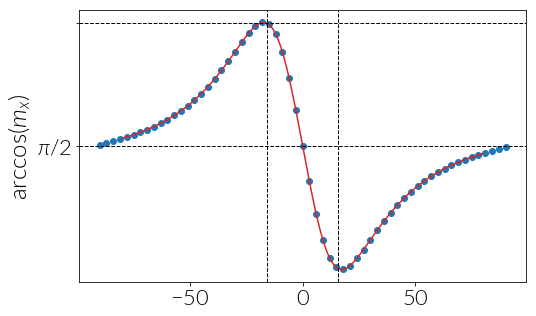

In [14]:
f = scipy.interpolate.interp1d(x_fidimag(0), np.arccos(mx_fidimag(0)), kind='cubic')

plt.plot(x_fidimag(0), np.arccos(mx_fidimag(0)), 'o', label=r'$z=$' + '{}'.format(zs[0]))

xi = np.linspace(-80, 80, 200)
plt.plot(xi, f(xi), '-C3')
plt.axhline(y=f(-r_sk_F), ls='--', c='k', lw=1)

plt.axvline(x=r_sk_F, ls='--', c='k', lw=1)
plt.axvline(x=-r_sk_F, ls='--', c='k', lw=1)

plt.yticks([np.pi * 0.5, f(-r_sk_F)])
plt.gca().set_yticklabels([r'$\pi/2$'])

plt.axhline(y=np.pi * 0.5, ls='--', c='k', lw=1)

plt.ylabel(r'$\arccos(m_{x})$')

# plt.ylim(-1, 1)

From [PRB **87**, 094424 (2013)], at the surfaces $\tilde{\Psi}=\pi L/L_{D}$, hence we can compare with the $\Psi$ value from the simulation at $r=r_{\text{sk}}$

In [15]:
# At r=r_sk , Theta=pi/2 --> Psi = arccos mx
f = scipy.interpolate.interp1d(x_fidimag(0), np.arccos(mx_fidimag(0)), kind='cubic')
# xmax = scipy.optimize.fmin(f, 0)[0]

print('Psi = arccos(mx(r=r_sk)) = ', f(-r_sk_F))

Psi = arccos(mx(r=r_sk)) =  2.165380839441658


And from the theory:

In [16]:
L = (zs[-1] - zs[0]) * 1e-9 # m
print('PI * L / L_D = ', np.pi * (L) / L_D + np.pi * 0.5)
 

PI * L / L_D =  2.470568536362095


Dependence of the radial component with respect to the $z$ position at three different (x,y) positions at every $z$ layer

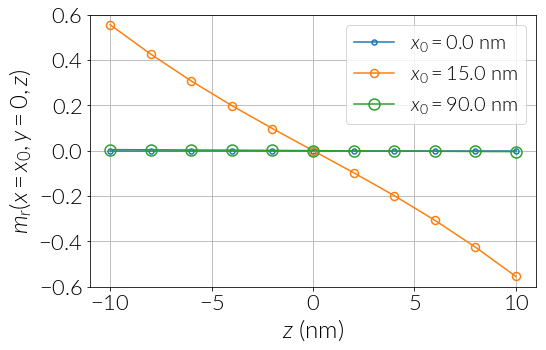

In [17]:
plt.figure(figsize=(8, 8 / 1.6))

for i, z_index in enumerate([30, 35, -1]):
    mrs = [mr_fidimag(i)[z_index] for i, mri in enumerate(zs_F)]
    plt.plot(zs_F, mrs, 'o-',
             label=r'$x_{0}=$' + '{}'.format(xs_F[z_index]) + ' nm',
             markerfacecolor='None', ms=3 * (i + 1) + 2, mew=1.5
             )

plt.ylabel(r'$m_{r}(x=x_{0},y=0,z)$')
plt.xlabel(r'$z$ (nm)')
plt.grid()
plt.legend()

plt.ylim(-0.6, 0.6)
plt.savefig('../paper/result_3d_linear_psi.pdf', bbox_inches='tight')

# OOMMF Simulation

In [18]:
base_folder = '../sims/'
omf_file = glob.glob(base_folder + '3D_OOMMF/oommf_3D_bulk-Oxs*.omf')[0]
oommf_data = pd.read_csv(omf_file, 
                         comment='#', header=None, delim_whitespace=True)
oommf_data = oommf_data.as_matrix()

# Scale the coordinates and the magnetization:
oommf_data[:, :3] *= 1e9 
oommf_data[:, 3:] /= Ms

Extract the coordinates and components of the magnetization. We create a `_filter_y_O` to extract the spins at a specific layer in the $z$ direction and at a line across the center of this layer (where the skyrmion is located) so we can compare the skyrmion profile at every layer. We also compute the cylindrical components of the magnetization.

In [19]:
# Extract the coordinates and shift them with respect to the mesh center
r_oommf = oommf_data[:, :3]
x, y, z = r_oommf[:, 0], r_oommf[:, 1], r_oommf[:, 2]
centre_x = x.min() + (x.max() - x.min()) * 0.5
centre_y = y.min() + (y.max() - y.min()) * 0.5
centre_z = z.min() + (z.max() - z.min()) * 0.5

x_O, y_O, z_O = (r_oommf[:, 0] - centre_x,
                 r_oommf[:, 1] - centre_y,
                 r_oommf[:, 2] - centre_z)

# Magnetization coordinates of the whole mesh
mx_O, my_O, mz_O = oommf_data[:, 3], oommf_data[:, 4], oommf_data[:, 5]

# We will mask the array to extract only the spins at y=y_mid (middle of the sample)
xs_O, ys_O, zs_O = np.unique(x_O), np.unique(y_O), np.unique(z_O)
_filter_y_O = lambda z_i: np.logical_and(y_O == ys_O[int(len(ys_O) * 0.5)], z_O == zs_O[z_i])

# Functions for the coordinates and magnetization extracted for a specific layer
mz_oommf = lambda z_i: mz_O[_filter_y_O(z_i)]
my_oommf = lambda z_i: my_O[_filter_y_O(z_i)]
mx_oommf = lambda z_i: mx_O[_filter_y_O(z_i)]
x_oommf = lambda z_i: x_O[_filter_y_O(z_i)]
y_oommf = lambda z_i: y_O[_filter_y_O(z_i)]
# z_oommf = lambda z_i: z[_filter_y_oommf(z_i)]

# Same for cylindrical coordinates
phi_O = np.arctan2(y_O, x_O)
mphi_oommf = lambda z_i: (-mx_O * np.sin(phi_O) + my_O * np.cos(phi_O))[_filter_y_O(z_i)]
mr_oommf = lambda z_i: (mx_O * np.cos(phi_O) + my_O * np.sin(phi_O))[_filter_y_O(z_i)]

The skyrmion radius across the sample. We then use the value from the bottom layer (index 0):

In [20]:
for i, z in enumerate(zs_O):
    f = scipy.interpolate.interp1d(x_oommf(i), mz_oommf(i), kind='cubic')
    # Skyrmion radius: m_z = 0
    rsk = scipy.optimize.brentq(f, 0, 50)
    
    if i == 0:
        r_sk_O = rsk

    print('At z = {:<6.2f}, r_sk = {:.3f}'.format(z, rsk))

At z = -10.00, r_sk = 15.746
At z = -8.00 , r_sk = 15.823
At z = -6.00 , r_sk = 15.925
At z = -4.00 , r_sk = 16.019
At z = -2.00 , r_sk = 16.084
At z = 0.00  , r_sk = 16.106
At z = 2.00  , r_sk = 16.084
At z = 4.00  , r_sk = 16.019
At z = 6.00  , r_sk = 15.925
At z = 8.00  , r_sk = 15.823
At z = 10.00 , r_sk = 15.746


As we did for the Fidimag simulations we can plot the cylindrical components for two different layers:

No handles with labels found to put in legend.


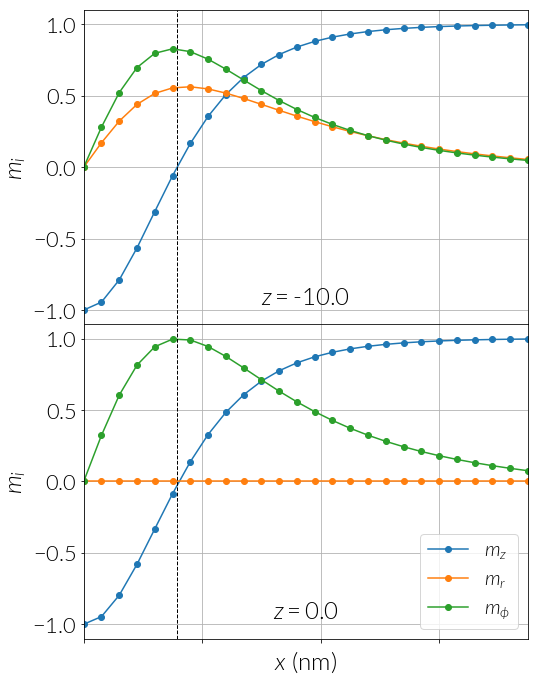

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 16 / 1.6))

# -----------------------------------------------------------------------------
# Plot at zs_F[0] --> this is z = -10 nm

ax1.plot(x_oommf(0), mz_oommf(0), 'o-', label=r'$m_{z}$')
ax1.plot(x_oommf(0), mr_oommf(0), 'o-', label=r'$m_{r}$')
ax1.plot(x_oommf(0), mphi_oommf(0), 'o-', label=r'$m_{\phi}$')

ax1.axvline(x=r_sk_O, color='k', lw=1, ls='--')

ax1.grid()
plt.legend(loc=4)
ax1.set_xlim(0, 75)
ax1.set_ylim(-1.1, 1.1)

ax1.set_xlabel(r'$x$ (nm)')
ax1.set_ylabel(r'$m_{i}$')

ax1.text(0.5, 0.05, r'$z=$' + '{}'.format(zs_O[0]),
         horizontalalignment='center', verticalalignment='bottom', 
         transform=ax1.transAxes)

# -----------------------------------------------------------------------------
# Plot at zs_F[5] --> this is z = 0 nm (middle of the sample)

ax2.plot(x_oommf(5), mz_oommf(5), 'o-', label=r'$m_{z}$')
ax2.plot(x_oommf(5), mr_oommf(5), 'o-', label=r'$m_{r}$')
ax2.plot(x_oommf(5), mphi_oommf(5), 'o-', label=r'$m_{\phi}$')

ax2.axvline(x=r_sk_O, color='k', lw=1, ls='--')

ax2.grid()
ax2.legend(loc=4)
ax2.set_xlim(0, 75)
ax2.set_ylim(-1.1, 1.1)

ax2.set_xlabel(r'$x$ (nm)')
ax2.set_ylabel(r'$m_{i}$')

ax2.text(0.5, 0.05, r'$z=$' + '{}'.format(zs_O[5]),
         horizontalalignment='center', verticalalignment='bottom', 
         transform=ax2.transAxes)

ax2.set_xticklabels([])

# -----------------------------------------------------------------------------

plt.tight_layout()
plt.subplots_adjust(hspace=0)
# plt.savefig('../paper/result_3d_oommf.pdf', bbox_inches='tight')

We can compute the radial component of spins as a function of $z$ at specific $(x, y)$ positions in every layer:

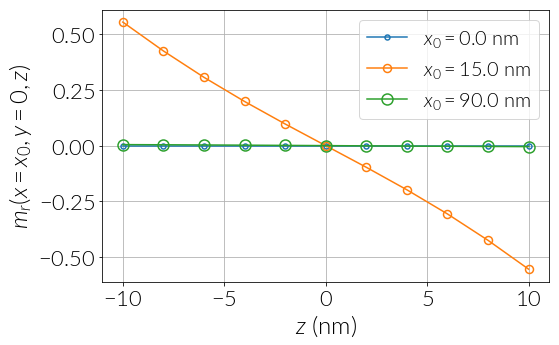

In [22]:
for i, z_index in enumerate([30, 35, -1]):
    mrs = [mr_oommf(i)[z_index] for i, mri in enumerate(zs_O)]
    plt.plot(zs_O, mrs, 'o-',
             label=r'$x_{0}=$' + '{}'.format(xs_O[z_index]) + ' nm',
             markerfacecolor='None', ms=3 * (i + 1) + 2, mew=1.5
             )

plt.ylabel(r'$m_{r}(x=x_{0},y=0,z)$')
plt.xlabel(r'$z$ (nm)')
plt.grid()
plt.legend()

# plt.savefig('../paper/result_3d_linear_psi_oommf.pdf', bbox_inches='tight')

# MuMax3 Simulation

These calculations are equivalent to the ones made using OOMMF. MuMax3 does not accept an odd number of cells thus we use a slightly different number of cells and mesh discretisation that is closer to the OOMMF and Fidimag simulations.

In [23]:
mumax_data = pd.read_csv('../sims/MUMAX3/3D/isolated_sk_FeGe_cuboid.ovf', 
                         comment='#', header=None, delim_whitespace=True)
mumax_data = mumax_data.as_matrix()
mumax_data[:, :3] *= 1e9

In [24]:
# Extract coordinates and shift positiins with respect to the middle points
# in the three spatial directions
r_mumax = mumax_data[:, :3]
x, y, z = r_mumax[:, 0], r_mumax[:, 1], r_mumax[:, 2]
centre_x = x.min() + (x.max() - x.min()) * 0.5
centre_y = y.min() + (y.max() - y.min()) * 0.5
centre_z = z.min() + (z.max() - z.min()) * 0.5

x_M, y_M, z_M = (r_mumax[:, 0] - centre_x,
                 r_mumax[:, 1] - centre_y,
                 r_mumax[:, 2] - centre_z)

mx_M, my_M, mz_M = mumax_data[:, 3], mumax_data[:, 4], mumax_data[:, 5]

# We will mask the array to extract only the spins at y=y_mid (middle of the sample)
xs_M, ys_M, zs_M = np.unique(x_M), np.unique(y_M), np.unique(z_M)
_filter_y_M = lambda z_i: np.logical_and(y_M == ys_M[int(len(ys_M) * 0.5)], z_M == zs_M[z_i])

mz_mumax = lambda z_i: mz_M[_filter_y_M(z_i)]
my_mumax = lambda z_i: my_M[_filter_y_M(z_i)]
mx_mumax = lambda z_i: mx_M[_filter_y_M(z_i)]
x_mumax = lambda z_i: x_M[_filter_y_M(z_i)]
y_mumax = lambda z_i: y_M[_filter_y_M(z_i)]
# z_oommf = lambda z_i: z[_filter_y_oommf(z_i)]

phi_M = np.arctan2(y_M, x_M)
mphi_mumax = lambda z_i: (-mx_M * np.sin(phi_M) + my_M * np.cos(phi_M))[_filter_y_M(z_i)]
mr_mumax = lambda z_i: (mx_M * np.cos(phi_M) + my_M * np.sin(phi_M))[_filter_y_M(z_i)]

We can compute the limits in the $x,y,z$ direction to prove the system has similar coordinates than the OOMMF and Fidimag simulations:

In [25]:
xs, ys, zs = np.unique(x_M), np.unique(y_M), np.unique(z_M)
print('x_min =', np.min(xs), 'xmax =', np.max(xs))
print('y_min =', np.min(ys), 'ymax =', np.max(ys))
print('z_min =', np.min(zs), 'zmax =', np.max(zs))

x_min = -90.02419354838709 xmax = 90.02419354838709
y_min = -90.02419354838709 ymax = 90.02419354838709
z_min = -10.08333333333333 zmax = 10.083333333333332


The skyrmion radius in MuMax3 differs from OOMMF and Fidimag:

In [26]:
for i, z in enumerate(zs_M):
    f = scipy.interpolate.interp1d(x_mumax(i), mz_mumax(i), kind='cubic')
    # Skyrmion radius: m_z = 0
    rsk = scipy.optimize.brentq(f, 0, 50)
    
    if i == 0:
        r_sk_M = rsk

    print('At z = {:<6.2f}, r_sk = {:.3f}'.format(z, rsk))

At z = -10.08, r_sk = 17.428
At z = -8.25 , r_sk = 17.513
At z = -6.42 , r_sk = 17.631
At z = -4.58 , r_sk = 17.745
At z = -2.75 , r_sk = 17.833
At z = -0.92 , r_sk = 17.880
At z = 0.92  , r_sk = 17.881
At z = 2.75  , r_sk = 17.835
At z = 4.58  , r_sk = 17.749
At z = 6.42  , r_sk = 17.636
At z = 8.25  , r_sk = 17.519
At z = 10.08 , r_sk = 17.435


We plot again the cylindrical coordinates in two layers. According to the mesh discretisation in the MuMax3 simulations, it is not possible to exactly plot the $z=0$ layer but we can do for the nearest $z$ coordinate. In this case we show the bottom and nearly center layer of the cube:

No handles with labels found to put in legend.


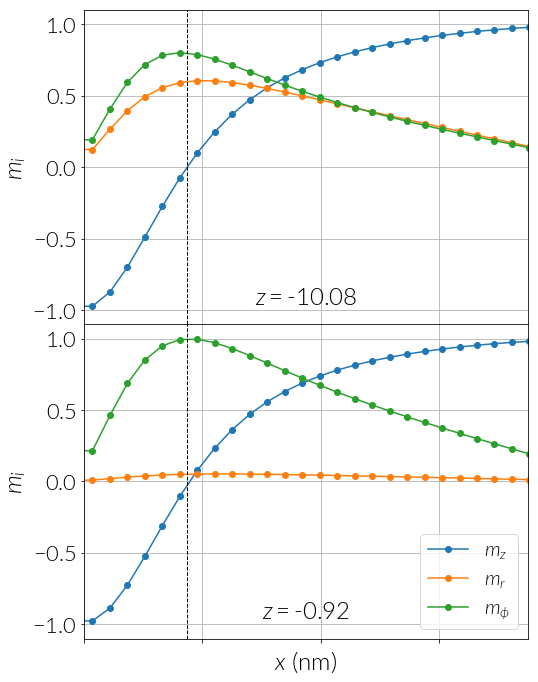

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 16 / 1.6))

# -----------------------------------------------------------------------------
# Plot at zs_F[0] --> this is z = -10 nm

ax1.plot(x_mumax(0), mz_mumax(0), 'o-', label=r'$m_{z}$')
ax1.plot(x_mumax(0), mr_mumax(0), 'o-', label=r'$m_{r}$')
ax1.plot(x_mumax(0), mphi_mumax(0), 'o-', label=r'$m_{\phi}$')

ax1.axvline(x=r_sk_M, color='k', lw=1, ls='--')

ax1.grid()
plt.legend(loc=4)
ax1.set_xlim(0, 75)
ax1.set_ylim(-1.1, 1.1)

ax1.set_xlabel(r'$x$ (nm)')
ax1.set_ylabel(r'$m_{i}$')

ax1.text(0.5, 0.05, r'$z=$' + '{:.2f}'.format(zs_M[0]),
         horizontalalignment='center', verticalalignment='bottom', 
         transform=ax1.transAxes)

# -----------------------------------------------------------------------------
# Plot at zs_F[5] --> this is z = 0 nm (middle of the sample)

ax2.plot(x_mumax(5), mz_mumax(5), 'o-', label=r'$m_{z}$')
ax2.plot(x_mumax(5), mr_mumax(5), 'o-', label=r'$m_{r}$')
ax2.plot(x_mumax(5), mphi_mumax(5), 'o-', label=r'$m_{\phi}$')

ax2.axvline(x=r_sk_M, color='k', lw=1, ls='--')

ax2.grid()
ax2.legend(loc=4)
ax2.set_xlim(0, 75)
ax2.set_ylim(-1.1, 1.1)

ax2.set_xlabel(r'$x$ (nm)')
ax2.set_ylabel(r'$m_{i}$')

ax2.text(0.5, 0.05, r'$z=$' + '{:.2f}'.format(zs_M[5]),
         horizontalalignment='center', verticalalignment='bottom', 
         transform=ax2.transAxes)

ax2.set_xticklabels([])

# -----------------------------------------------------------------------------

plt.tight_layout()
plt.subplots_adjust(hspace=0)
# plt.savefig('../paper/result_3d_mumax.pdf', bbox_inches='tight')

We can compute the radial profile across the sample thickness. The discretisation of the mesh is slightly different in MuMax3 but the sample dimensions are very similar.

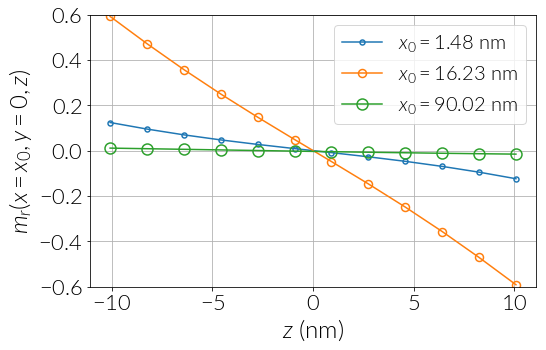

In [28]:
for i, z_index in enumerate([31, 36, -1]):
    mrs = [mr_mumax(i)[z_index] for i, mri in enumerate(zs_M)]
    plt.plot(zs_M, mrs, 'o-',
             label=r'$x_{0}=$' + '{:.2f}'.format(xs_M[z_index]) + ' nm',
             markerfacecolor='None', ms=3 * (i + 1) + 2, mew=1.5
             )

plt.ylabel(r'$m_{r}(x=x_{0},y=0,z)$')
plt.xlabel(r'$z$ (nm)')
plt.grid()
plt.legend()

plt.ylim(-0.6, 0.6)

plt.savefig('../paper/result_3d_mr_across_z_mumax3.pdf', bbox_inches='tight')

The skyrmion profile is still equivalent to the other softwares:

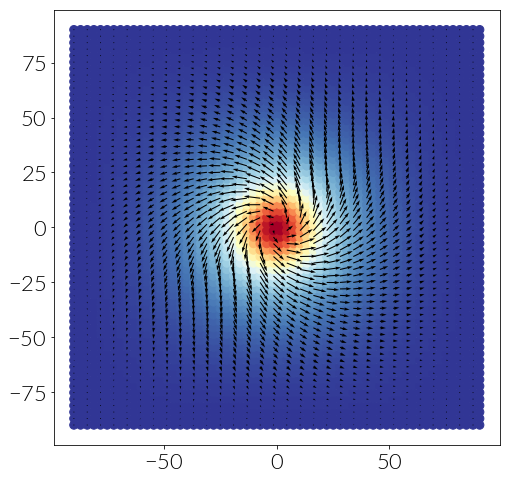

In [29]:
plt.figure(figsize=(8, 8))
fy = z_M == zs_M[0]
plt.scatter(x_M[fy], y_M[fy], c=mz_M[fy], s=70, cmap='RdYlBu')
plt.quiver(x_M[fy][::2], y_M[fy][::2], mx_M[fy][::2], my_M[fy][::2])

# Comparison between software

In [30]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

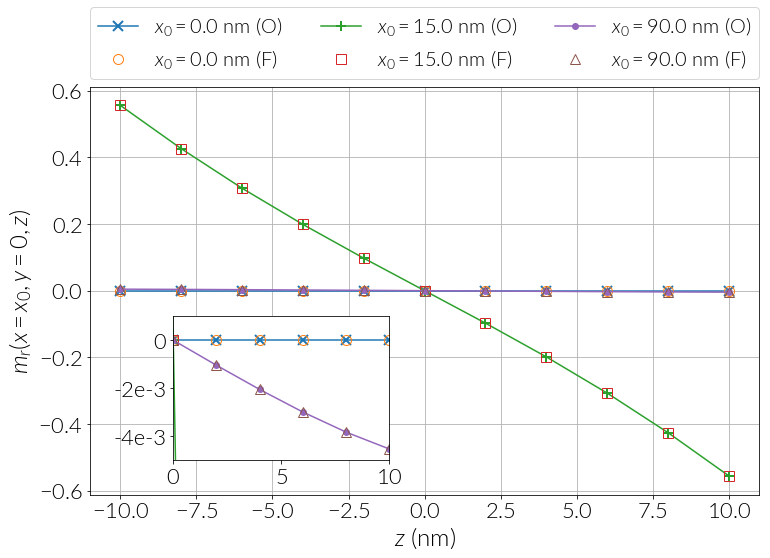

In [31]:
f = plt.figure(figsize=(12, 12 / 1.6))
ax = f.add_subplot(111)

axins = inset_axes(ax, 3, 2 , loc=3, bbox_to_anchor=(0.21, 0.17),
                   bbox_transform=ax.figure.transFigure) # no zoom

marks = ['x', '+', '.', 'o', 's', '^']
for i, xi in enumerate([30, 35, -1]):
    
    for a in [ax, axins]:
        mrs = [mr_oommf(i)[xi] for i, mri in enumerate(zs_O)]
        a.plot(zs_F, mrs, '-', marker=marks[i], mew=2, ms=10,
                label=r'$x_{0}=$' + '{}'.format(xs_O[xi]) + ' nm (O)')

        mrs = [mr_fidimag(i)[xi] for i, mri in enumerate(zs_F)]
        a.plot(zs_F, mrs, '', marker=marks[i + 3],
                markerfacecolor='None', ms=10, mew=1,
                lw=0,
                label=r'$x_{0}=$' + '{}'.format(xs_F[xi]) + ' nm (F)')
        
axins.set_xlim(0, 10)
axins.set_ylim(-0.005, 0.001)
axins.set_yticks([0, -2e-3, -4e-3])
axins.set_yticklabels(['0', '-2e-3', '-4e-3'])
    
ax.set_ylabel(r'$m_{r}(x=x_{0},y=0,z)$')
ax.set_xlabel(r'$z$ (nm)')
ax.grid()

ax.legend(ncol=3, loc='lower left', bbox_to_anchor=(0, 1.02, 1.0, 1),
          mode='expand', borderaxespad=0.)

# plt.ylim(-0.1, 0.1)

plt.savefig('../paper/result_3d_mr_codes-comparison.pdf', bbox_inches='tight')